In [70]:
!python3 --version
import librosa
import librosa.display
import numpy as np
import pandas as pd
import os


Python 3.9.6


In [42]:
# DEPRECATED
#from google.colab import drive
#
# This will prompt for authorization.
#drive.mount('/content/drive', force_remount=True)

In [71]:
RECORDINGS_PATH = "/Users/ntuan1/workspaces/content/drive/MyDrive/amd-training/"
os.chdir(RECORDINGS_PATH)
df = pd.read_pickle("amd-df-01-29-10-41.pkl")



#convert label seriers to ints
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
#print(df['label'].unique())
le.fit(df['label'].unique())
df['label'] = le.transform(df['label']) 

print("count:")
print(df.label.value_counts())
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)
class_names = le.classes_

df.head()


count:
label
0    16
1    15
Name: count, dtype: int64
{'beep': 0, 'speech': 1}


,file_path,mfccs_40,chroma,mel,contrast,tonnetz,duration,label
0,answering-machine/beep-02.wav,"[-97.78767, 1.9121733, 8.148039, 23.516476, -1...","[0.15613975, 0.12301526, 0.25473025, 0.1193895...","[0.613094, 0.61335605, 0.63427126, 1.7503637, ...","[14.678567527402118, 13.203839754553197, 37.35...","[-0.4782227162056115, 0.3718096774090598, -0.0...",0.30425,0
2,answering-machine/beep-01.wav,"[-392.9721, 11.7795515, -23.080708, -50.315006...","[0.17693055, 0.013545142, 0.013969152, 0.02721...","[0.014008737, 0.013968677, 0.014187551, 0.0141...","[13.434110939386256, 13.814635558162719, 20.57...","[0.33142135384491156, -0.37640093915571327, 0....",0.71525,0
4,answering-machine/beep-07a.wav,"[-235.76114, 40.16065, -103.155655, 6.074047, ...","[0.050724536, 0.042279888, 0.039348125, 0.0486...","[0.027249826, 0.027581772, 0.027397785, 0.0280...","[5.505918409818085, 5.340020185011622, 8.35250...","[0.3905417870636931, -0.09732974048305179, -0....",0.109562,0
6,answering-machine/beep-04.wav,"[-435.2159, -18.246925, -19.837187, 28.130121,...","[0.008847945, 0.009358507, 0.014058292, 0.1542...","[0.0023672127, 0.0023645815, 0.0023648916, 0.0...","[12.777616746914498, 16.147585224185097, 22.17...","[0.4677219858046245, -0.1364208666012615, -0.2...",0.596313,0
8,answering-machine/beep-06.wav,"[-300.8038, -41.312534, 10.463231, 29.02023, 6...","[0.028244575, 0.031693, 0.039061435, 0.1646129...","[15.509576, 0.41655105, 0.16578466, 0.0901023,...","[32.08670058857618, 14.324684317775532, 14.495...","[0.3143235979148737, -0.054864055715061665, -0...",0.265,0


In [72]:
#remove files with durations longer than 10 seconds
df = df.copy()
df = df.drop(df[ df['duration']>10].index)
df.reset_index(drop=True, inplace=True)
print(df.label.value_counts())


label
0    16
1     8
Name: count, dtype: int64


In [73]:
from sklearn import metrics
import matplotlib.pyplot as plt
import itertools
#from sklearn.externals import joblib
import joblib
#from google.colab import files
import datetime
import pickle


def print_classification_results(y_test, res):
    print(metrics.accuracy_score(y_test, res))
    print(metrics.classification_report(y_test, res))
    print(metrics.confusion_matrix(y_test, res))
    print("")

    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def save_model(model, model_name):
  filename = "{}-{}.pkl".format(model_name, datetime.datetime.now().strftime("%Y%m%dT%H%M"))
  pickle.dump(model, open(filename, 'wb'))
  #files.download(filename)
  


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

def generateFeaturesLabels(features_list):
  total_features_len = np.sum([len(df[feature][0]) for feature in features_list])
  print("total number of features",total_features_len)
  features, labels = np.empty((0,total_features_len)), np.empty(0)
  for _, row in df.iterrows():
    a = []
    for feature in features_list:
      a.append(row[feature])
      
    features = np.vstack([features,np.hstack(a)])
    labels = np.append(labels, row["label"])
  return np.array(features), np.array(labels, dtype = np.int64)

def train(features, model):
  X, y = generateFeaturesLabels(features)
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
  
  model.fit(x_train, y_train)
  print("Score:",model.score(x_test, y_test))
  
  cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='f1_macro')
  print("cross_val_scores:", cross_val_scores)
  print("Accuracy: %0.2f (+/- %0.2f)" % (cross_val_scores.mean(), cross_val_scores.std() * 2))
  
  predictions = model.predict(x_test)

  # Calculate and print the precision
  precision = precision_score(y_test, predictions, average='macro', zero_division=0)
  print("Precision:", precision)

  print_classification_results(y_test, predictions)
  
  cm = metrics.confusion_matrix(y_test, predictions)
  plot_confusion_matrix(cm, class_names)
  
  print("*** Scaled ***")
  scaler = preprocessing.StandardScaler().fit(x_train)
  x_train_transformed = scaler.transform(x_train)
  scaled_model = model.fit(x_train_transformed, y_train)
  x_test_transformed = scaler.transform(x_test)
  print("scaled_model score:",model.score(x_test_transformed, y_test))
  
  return model
  
### GridSearchCV
# there are a few improvements you could consider:
# 1. **Parameter Tuning**: You could use GridSearchCV or RandomizedSearchCV from sklearn.model_selection to find the best hyperparameters for your model. This could help improve the performance of your model.\
# 2. **Feature Importance**: After training the model, you could print the feature importances. This could give you insights into which features are most important for your model, and you could use this information to do feature selection.\
# 3. **Model Evaluation**: Besides precision, you could also calculate other metrics like recall, F1 score, and ROC AUC to get a more comprehensive understanding of your model's performance.
# 4. **Error Analysis**: You could analyze the instances that your model is misclassifying to understand where it's going wrong and how you might improve it.
# 5. **Cross-Validation**: You're currently using 2-fold cross-validation, which might not be enough to get a reliable estimate of your model's performance. You could consider using a larger number of folds, like 5 or 10.
# 6. **Scaling**: You could try scaling the features to see if that improves your model's performance.
# In this version of the `train` function, you would also need to pass in a dictionary of parameters to try for the grid search. For example, for a RandomForestClassifier, 
# you might pass in `params = {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]}`.

def trainV2(features, model, params):
  X, y = generateFeaturesLabels(features)
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
  
  # Parameter tuning
  grid_search = GridSearchCV(model, params, cv=5, scoring='f1_macro')
  grid_search.fit(x_train, y_train)
  print("Best parameters:", grid_search.best_params_)
  model = grid_search.best_estimator_
  
  model.fit(x_train, y_train)
  print("Score:",model.score(x_test, y_test))
  
  cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='f1_macro')
  print("cross_val_scores:", cross_val_scores)
  print("Accuracy: %0.2f (+/- %0.2f)" % (cross_val_scores.mean(), cross_val_scores.std() * 2))
  
  predictions = model.predict(x_test)

  # Calculate and print the precision
  precision = precision_score(y_test, predictions, average='macro', zero_division=0)
  print("Precision:", precision)
  
  # Calculate and print other metrics
  recall = recall_score(y_test, predictions, average='macro', zero_division=0)
  f1 = f1_score(y_test, predictions, average='macro',zero_division=0)
  roc_auc = roc_auc_score(y_test, predictions)
  print("Recall:", recall)
  print("F1 Score:", f1)
  print("ROC AUC:", roc_auc)
  
  print_classification_results(y_test, predictions)
  
  cm = metrics.confusion_matrix(y_test, predictions)
  plot_confusion_matrix(cm, class_names)
  
  print("*** Scaled ***")
  scaler = preprocessing.StandardScaler().fit(x_train)
  x_train_transformed = scaler.transform(x_train)
  scaled_model = model.fit(x_train_transformed, y_train)
  x_test_transformed = scaler.transform(x_test)
  print("scaled_model score:",model.score(x_test_transformed, y_test))
  
  # Print feature importances
  if hasattr(model, 'feature_importances_'):
    print("Feature importances:", model.feature_importances_)
  
  return model
 

# Training

## OneVsRest

total number of features 40
Best parameters: {}
Score: 1.0
cross_val_scores: [1. 1. 1. 1. 1.]
Accuracy: 1.00 (+/- 0.00)
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

[[5 0]
 [0 3]]

Confusion matrix, without normalization
[[5 0]
 [0 3]]
*** Scaled ***
scaled_model score: 0.75


OneVsRestClassifier(estimator=LogisticRegression(max_iter=4000))

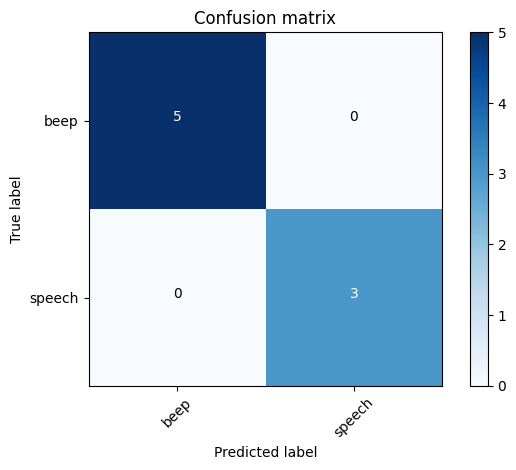

In [74]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
base_lr = LogisticRegression(solver='lbfgs', max_iter=4000)
ovr = OneVsRestClassifier(base_lr)
# V1
# train(['mfccs_40'], ovr)

# V2
trainV2(['mfccs_40'], ovr, {})

In [75]:
save_model(ovr,"ovr")

## RandomForest

total number of features 40
Best parameters: {'max_depth': None, 'n_estimators': 50}
Score: 1.0
cross_val_scores: [1. 1. 1. 1. 1.]
Accuracy: 1.00 (+/- 0.00)
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

[[5 0]
 [0 3]]

Confusion matrix, without normalization
[[5 0]
 [0 3]]
*** Scaled ***
scaled_model score: 1.0
Feature importances: [0.01230769 0.13371429 0.00888889 0.02       0.01446553 0.0379425
 0.07085714 0.04726003 0.03073105 0.07043605 0.02769921 0.02009877
 0.01955556 0.02602686 0.03264558 0.01230769 0.00775758 0.03240404
 0.00831169 0.02628571 0.         0.02       0.03086203 0.01226374
 0.         0.         0.         0.07879365 0.03444092 0.01

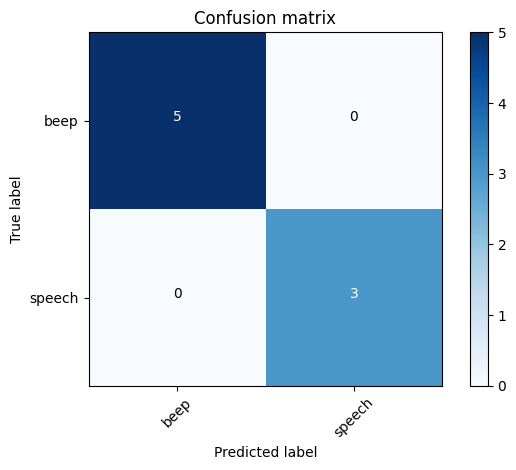

In [76]:
features_to_include = ['mfccs_40']
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 50)
# V1
#rf = trainV2(features_to_include, model
# V2
params = {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]}
rf = trainV2(features_to_include, model, params)

In [77]:
#working model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

rf = RandomForestClassifier(n_estimators = 100)
X = list(df.mfccs_40.values)
y = df.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

fit_model = rf.fit(X_train, y_train)

In [78]:
save_model(fit_model,"rf")

## XGBoost

total number of features 40
Best parameters: {'max_depth': None, 'n_estimators': 10}
Score: 1.0
cross_val_scores: [1. 1. 1. 1. 1.]
Accuracy: 1.00 (+/- 0.00)
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

[[5 0]
 [0 3]]

Confusion matrix, without normalization
[[5 0]
 [0 3]]
*** Scaled ***
scaled_model score: 1.0
Feature importances: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

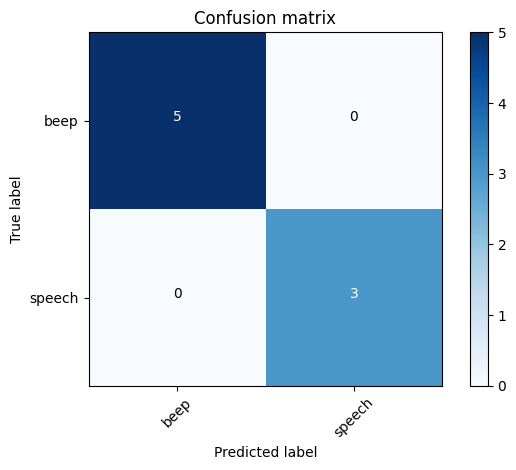

In [79]:
import xgboost as xgb

features_to_include = ['mfccs_40']
model = xgb.XGBClassifier()
# V1
# train(features_to_include, model)

# V2
params = {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]}
trainV2(features_to_include, model,params)

## LogisticRegression

total number of features 40
Best parameters: {}
Score: 1.0
cross_val_scores: [1. 1. 1. 1. 1.]
Accuracy: 1.00 (+/- 0.00)
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

[[5 0]
 [0 3]]

Confusion matrix, without normalization
[[5 0]
 [0 3]]
*** Scaled ***
scaled_model score: 0.75


LogisticRegression(max_iter=200, solver='liblinear')

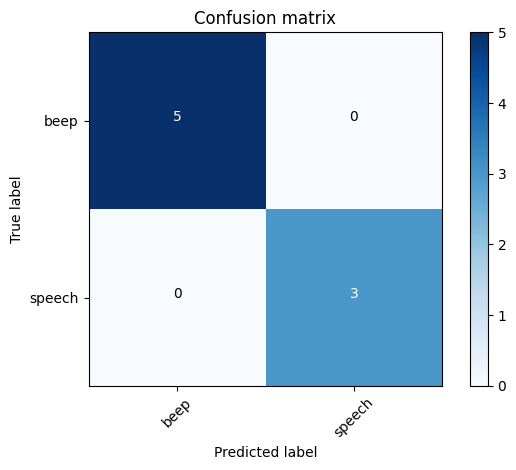

In [80]:
from sklearn.linear_model import LogisticRegression

features_to_include = ['mfccs_40']
logisticRegr = LogisticRegression(solver='liblinear', max_iter=200)
# V1
# train(features_to_include, logisticRegr)

# V2
trainV2(features_to_include, logisticRegr,{})

## SVM

total number of features 40
Best parameters: {}
Score: 0.875
cross_val_scores: [1.         1.         1.         0.76190476 1.        ]
Accuracy: 0.95 (+/- 0.19)
Precision: 0.9166666666666667
Recall: 0.8333333333333333
F1 Score: 0.8545454545454545
ROC AUC: 0.8333333333333333
0.875
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.67      0.80         3

    accuracy                           0.88         8
   macro avg       0.92      0.83      0.85         8
weighted avg       0.90      0.88      0.87         8

[[5 0]
 [1 2]]

Confusion matrix, without normalization
[[5 0]
 [1 2]]
*** Scaled ***
scaled_model score: 1.0


SVC()

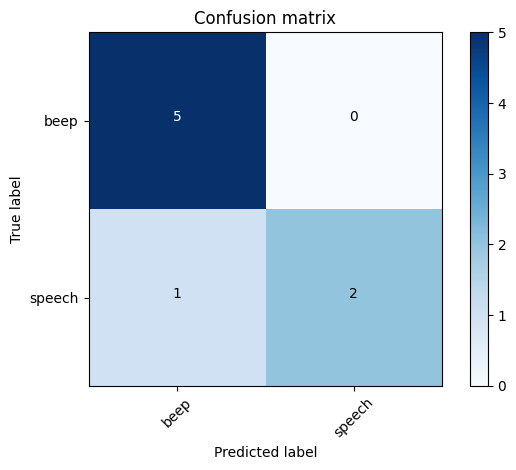

In [81]:
from sklearn import svm
svm = svm.SVC(gamma='scale')
features_to_include = ['mfccs_40']

# V1
# train(features_to_include, svm)

# V2
trainV2(features_to_include, svm,{})

#Save Model

In [82]:
import pickle
import datetime
filename = "rf-{}.pkl".format(datetime.datetime.now().strftime("%Y%m%dT%H%M"))
print(filename)
pickle.dump(rf, open(filename, 'wb'))

rf-20240129T1511.pkl
